R => Python  
Source: https://web.stanford.edu/class/stats191/notebooks/Correlated_errors.html


NOTE: 
* Not exactly porting R to Python.
* Also not [rpy2](https://rpy2.readthedocs.io/en/version_2.8.x/)

# Correlated Errors

Today, we will consider another departure from our usual model for the variance
(i.e. equal variance $\sigma^2$ and independent).

Before we do this, let's refresh our memory on *weighted least squares.*

In [64]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.stattools import durbin_watson

In [2]:
sm.version.version

'0.9.0'

In [3]:
import scipy; scipy.__version__

'0.18.1'

## Weighted least squares

In the last set of notes, we considered a model
$$
Y = X\beta + \epsilon, \qquad \epsilon \sim N(0, W^{-1})
$$
where
$$
W^{-1} = \sigma^2 \cdot \text{diag}(V_1, \dots, V_n).
$$

This model has independent errors, but of different variance: a *heteroscedastic* model.

## The fix

We saw that by defining
$$
\tilde{Y} = W^{1/2}Y, \qquad \tilde{X} = W^{1/2}X
$$
we transformed our original model to more familiar model:
$$
\tilde{Y} = \tilde{X}\beta + \varepsilon, \qquad \varepsilon \sim N(0, \sigma^2 I).
$$

The usual estimator in this model is the *WLS* estimator
$$
\hat{\beta}_W = (X^TWX)^{-1}X^TWY.
$$



## The implications

If we ignore *heteroscedasticity* then our *OLS* estimator has
distribution
$$
\hat{\beta} = (X^TX)^{-1}X^TY \sim N(\beta, \sigma^2 (X^TX)^{-1} X^TW^{-1}X (X^TX)^{-1}).
$$

This form of the variance matrix is called the *sandwich form*. 

**This means that our `Std. Error` column will be off! In other words, `R` will report $t$ statistics that are off by some multiplicative factor!**

Another reason to worry about $W$ is that if we use the correct $W$, we have
a more *efficient* unbiased estimator: smaller confidence intervals.

## The implications

Using the correct $W$ *proportional to inverse variance of the errors* and
form the WLS estimator we have
$$
\hat{\beta}_{WLS} \sim N(\beta, \sigma^2 (X^TWX)^{-1}).
$$


## Autocorrelation

- The model of the variance that we will consider today 
is a model where the errors are *correlated*.

- In the random effects model, outcomes within groups were correlated.
Other regression applications also have correlated outcomes (i.e.
errors).

- Common examples of this type of errors occur in time series data, a
common model for financial applications.

### Why should we worry?
Just as in the *heteroscedastic case*, ignoring autocorrelation can lead to underestimates of `Std. Error` $\rightarrow$ inflated t's $\rightarrow$ false positives.

### What is autocorrelation?

* Suppose we plot Palo Alto's daily average temperature - clearly we
  would see a pattern in the data.

* Sometimes, this pattern can be attributed to a deterministic
  phenomenon (i.e. predictable seasonal fluctuations).

* Other times, "patterns" are due to correlations in the noise, maybe
  small time fluctuations in the stock market, economy, etc.

* Example: financial time series: NASDAQ close prices.

* Example: residuals regressing consumer expenditure on money stock (this one is discussed in your textbook and used as an example below).

### Average Max Temp in Palo Alto

The daily max temperature shows clear seasonal fluctuations.

In [4]:
filepath = os.path.join(os.path.curdir, "data", "paloaltoT.csv")
temp_data = pd.read_csv(filepath)
temp_data.head()

,MO,DY,AVG,NO,HI,YR,LO,YR.1,AVG.1,NO.1,...,HIGH.1,YR.5,AVG.4,NO.4,HIGH.2,YR.6,HDD,NO.5,CDD,NO.6
0,1,1,56,48,68,1997,44,1962,37,48,...,0.0,2003,0,49,0,2003,18.7,48,0.0,48
1,1,2,57,49,69,1996,46,1988,36,48,...,0.0,2003,0,50,0,2003,19.1,48,0.0,48
2,1,3,55,48,72,1996,47,1993,37,48,...,0.0,2003,0,50,0,2003,19.3,48,0.0,48
3,1,4,56,50,64,2001,43,1974,36,50,...,0.0,2003,0,50,0,2003,19.0,50,0.0,50
4,1,5,56,49,66,2001,45,1974,37,50,...,0.0,2003,0,50,0,2003,18.4,49,0.0,49


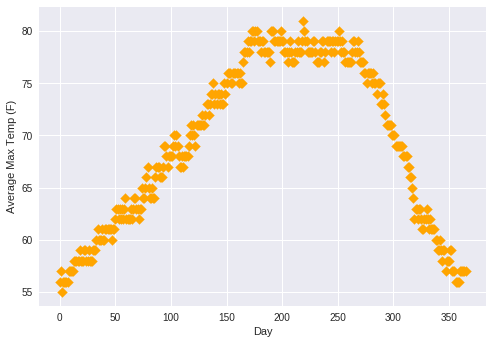

In [5]:
plt.scatter(temp_data.index, temp_data["AVG"], color='orange', marker='D')
plt.xlabel("Day")
plt.ylabel("Average Max Temp (F)")
plt.show()

### NASDAQ daily close 2011

- Another example of a time series can be found from financial data. 
The price of many assets fluctuate from day to day. 

- Still, there is a *pattern* in this process. 

- Given enough information, we might try to also explain
this pattern as a deterministic model, like the temperature data. (This is, in some sense, what business news sites try to do on a daily basis).

- A simpler model for this pattern is that of some unexplainable noise...

- Below, we plot some
closing prices of NASDAQ for the year 2011. Data was obtained from
on [yahoo finance](http://finance.yahoo.com).



In [6]:
filepath = os.path.join(os.path.curdir, "data", "nasdaq_2011.csv")
nasdaq_2011_data = pd.read_csv(filepath)
nasdaq_2011_data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2011-12-30,55.87,56.12,55.82,55.83,21832400,55.83
1,2011-12-29,55.68,56.03,55.50,55.99,28077900,55.99
2,2011-12-28,56.17,56.26,55.44,55.59,38180100,55.59
3,2011-12-27,55.99,56.42,55.93,56.24,21443500,56.24
4,2011-12-23,55.71,56.08,55.58,56.08,26594600,56.03


In [7]:
nasdaq_2011_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
Date         252 non-null object
Open         252 non-null float64
High         252 non-null float64
Low          252 non-null float64
Close        252 non-null float64
Volume       252 non-null int64
Adj Close    252 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [8]:
nasdaq_2011_data["Date"] = pd.to_datetime(nasdaq_2011_data["Date"])

/home/doojung/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


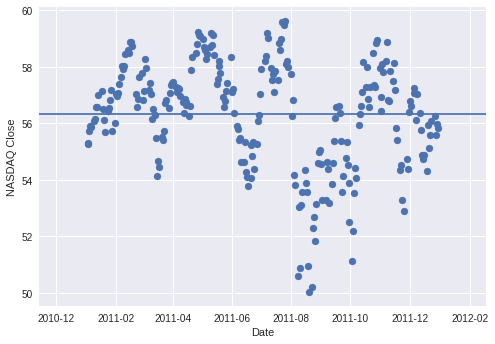

In [9]:
plt.scatter(nasdaq_2011_data["Date"], nasdaq_2011_data["Close"])
plt.xlabel("Date")
plt.ylabel("NASDAQ Close")
plt.axhline(nasdaq_2011_data["Close"].mean())
plt.show()

In [10]:
ndays = len(nasdaq_2011_data["Date"])
ndays

252

In [11]:
nasdaq_2011_data['Close'][1:ndays][:5].reset_index(drop=True)

0    55.99
1    55.59
2    56.24
3    56.08
4    55.60
Name: Close, dtype: float64

In [12]:
nasdaq_2011_data['Close'][0:ndays-1][:5]

0    55.83
1    55.99
2    55.59
3    56.24
4    56.08
Name: Close, dtype: float64

In [13]:
# daily log_returns are very small
log_return = np.log(nasdaq_2011_data['Close'][1:ndays].reset_index(drop=True) / \
                    nasdaq_2011_data['Close'][0:ndays-1])
log_return[:5]

0    0.002862
1   -0.007170
2    0.011625
3   -0.002849
4   -0.008596
Name: Close, dtype: float64

In [14]:
pd.set_option('float_format', '{:f}'.format)

In [15]:
log_return[:5]

0    0.002862
1   -0.007170
2    0.011625
3   -0.002849
4   -0.008596
Name: Close, dtype: float64

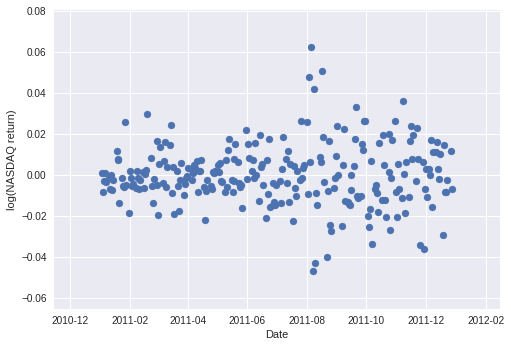

In [16]:
plt.scatter(nasdaq_2011_data["Date"][2:ndays], log_return[1:])
plt.xlabel("Date")
plt.ylabel("log(NASDAQ return)")
plt.show()

### NASDAQ daily close 2011, ACF

- One way this noise is measured is through the *ACF (Auto-Correlation Function)*, which we will define below.

- A time series with no auto-correlation (i.e. our usual multiple linear regression model) has an ACF that contains only a spike at 0.

- The NASDAQ close clearly has some auto-correlation.

In [17]:
def plot_acf_pacf(data, **kwargs):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(data, ax=ax1, **kwargs)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(data, ax=ax2, **kwargs)
    plt.show()
    
# Source: https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html

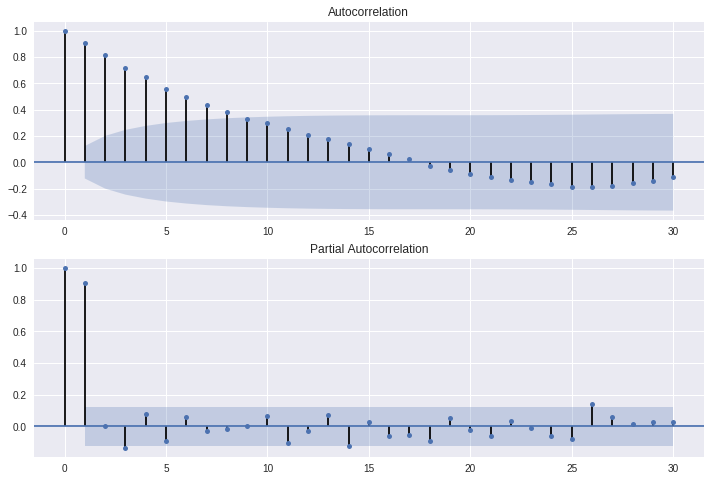

In [18]:
plot_acf_pacf(data=nasdaq_2011_data["Close"], lags=30)

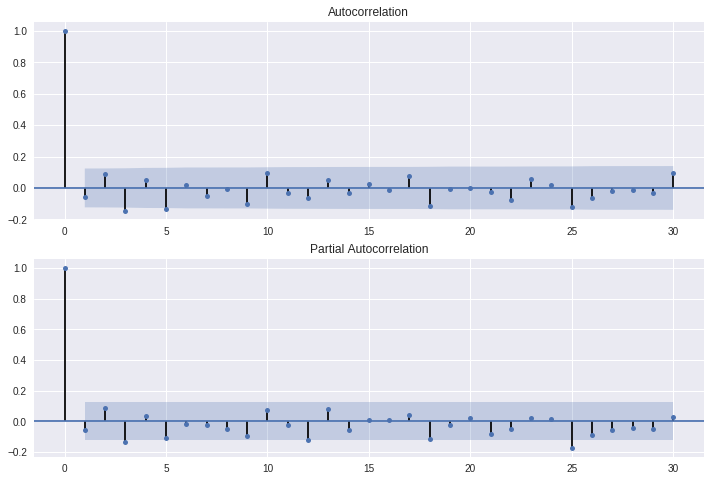

In [19]:
plot_acf_pacf(data=log_return, lags=30)

# ACF of independent noise

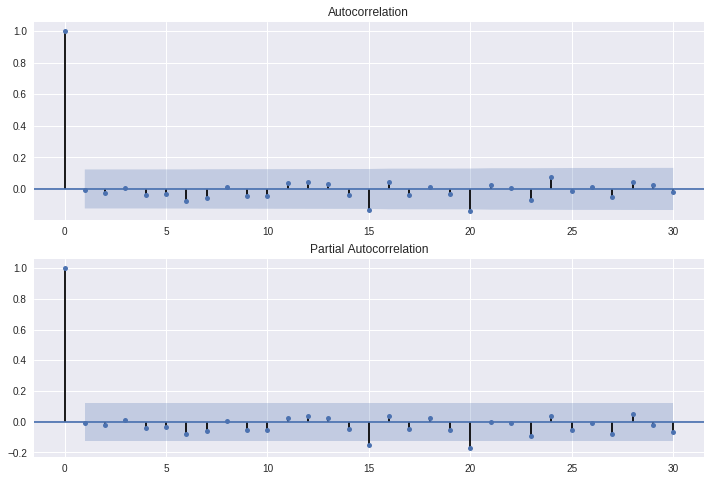

In [20]:
plot_acf_pacf(data=np.random.normal(size=nasdaq_2011_data.shape[0]), lags=30)

### Expenditure vs. stock

The example we will consider is that of *consumer expenditure* vs. *money stock*, the supply of available money in the economy.

Data is collected yearly, so perhaps there is autocorrelation in the model
$$
{\tt Expenditure}_t = \beta_0 + \beta_1 {\tt Stock}_t + \epsilon_t
$$


In [21]:
filepath = os.path.join(os.path.curdir, "data", "expenditure.table")
expenditure_data = pd.read_table(filepath)
expenditure_data.head()

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  from ipykernel import kernelapp as app


,Year,Quarter,Expenditure,Stock
0,1952,1,214.600000,159.300000
1,1952,2,217.700000,161.200000
2,1952,3,219.600000,162.800000
3,1952,4,227.200000,164.600000
4,1953,1,230.900000,165.900000


In [22]:
expenditure_data.columns

Index(['Year ', 'Quarter ', 'Expenditure ', 'Stock '], dtype='object')

In [23]:
expenditure_data.rename(columns={"Year ":"Year",
                               "Quarter ":"Quarter",
                               "Expenditure ":"Expenditure",
                               "Stock ":"Stock" 
                               }, inplace=True)
expenditure_data.columns

Index(['Year', 'Quarter', 'Expenditure', 'Stock'], dtype='object')

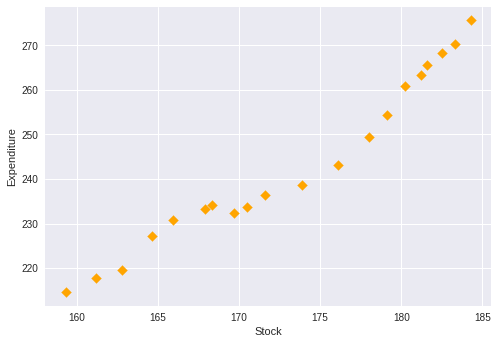

In [24]:
plt.scatter(expenditure_data["Stock"], 
            expenditure_data["Expenditure"], 
            color='orange', 
            marker='D')
plt.xlabel("Stock")
plt.ylabel("Expenditure")
plt.show()

### Expenditure vs. stock: residuals

A plot of residuals against `time`, i.e. their index may show 
evidence of autocorrelation.

In [25]:
expenditure_res = ols("Expenditure ~ Stock", data=expenditure_data).fit()
expenditure_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Expenditure   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     403.2
Date:                Tue, 25 Jun 2019   Prob (F-statistic):           8.99e-14
Time:                        11:32:42   Log-Likelihood:                -54.964
No. Observations:                  20   AIC:                             113.9
Df Residuals:                      18   BIC:                             115.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -154.7192     19.850     -7.794      0.000    -196.423    -113.016
Stock          2.3004      0.115     20.080      0.000       2.060       2.541
==============================================================================
Omnibus:                        2.018   Durbin-Watson:                   0.328
Prob(Omnibus):                  0.365   Jarque-Bera (JB):                1.446
Skew:                          -0.453   Prob(JB):                        0.485
Kurtosis:                       2.044   Cond. No.                     3.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

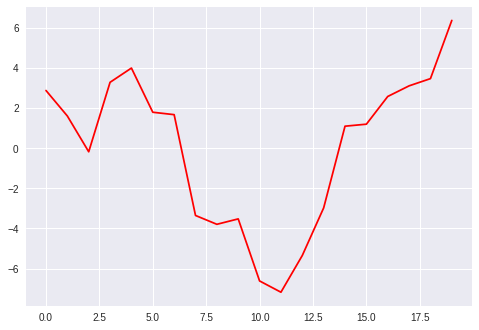

In [26]:
plt.plot(expenditure_res.resid, color='red')
plt.show()

### ACF of residuals

A plot of the ACF may also help. Since there seem to be some
points outside the confidence bands, this is some evidence that auto-correlation
is present in the errors.

/home/doojung/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


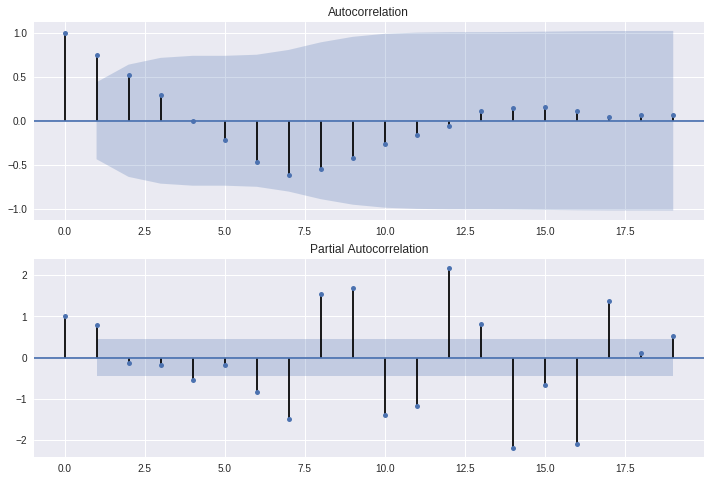

In [27]:
plot_acf_pacf(data=expenditure_res.resid)

## Models for correlated errors



### AR(1) noise

* Suppose that, instead of being independent, the errors in our model
  were $$\varepsilon_t = \rho \cdot \varepsilon_{t-1} + \omega_t, \qquad -1 <
  \rho < 1$$ with $\omega_t \sim N(0,\sigma^2)$ independent.
  
* If $\rho$ is close to 1, then errors are very correlated, $\rho=0$
  is independence.
  
* This is "Auto-Regressive Order (1)" noise (AR(1)). Many other models
  of correlation exist: ARMA, ARIMA, ARCH, GARCH, etc.

### AR(1) noise, $\rho=0.9$


In [28]:
np.random.seed(1000)

def make_sim_data(rho, nsample):    
    e = np.random.normal(size=nsample)
    w = np.random.normal(size=nsample)
    for t in range(nsample):
        e[t] = rho*e[t-1] + w[t]
    return e

In [29]:
nsample = 200
rho = 0.95

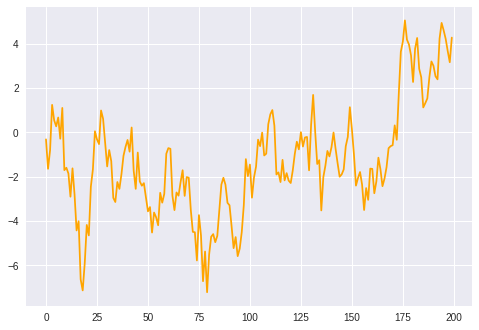

In [30]:
sim_data = make_sim_data(rho=rho, nsample=nsample)
plt.plot(sim_data, color='orange')
plt.show()

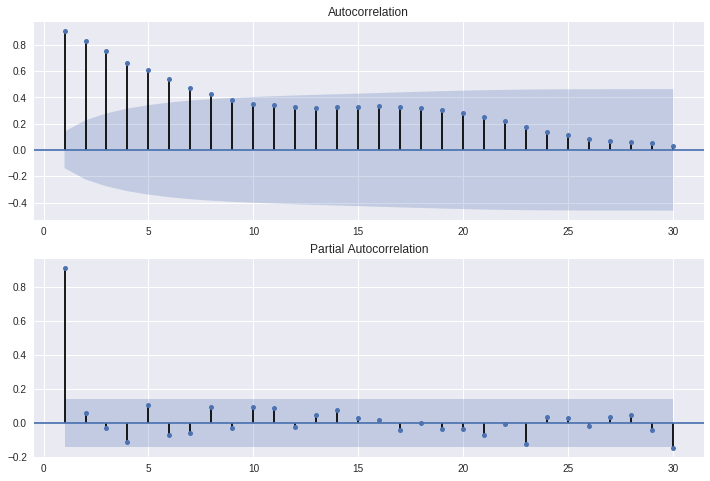

In [31]:
plot_acf_pacf(sim_data, lags=30, zero=False)

In [32]:
ar = np.array([1, -rho]) # negate
arma_process = ArmaProcess(ar)
sim_data = arma_process.generate_sample(nsample=nsample)

# Source: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ArmaProcess.html

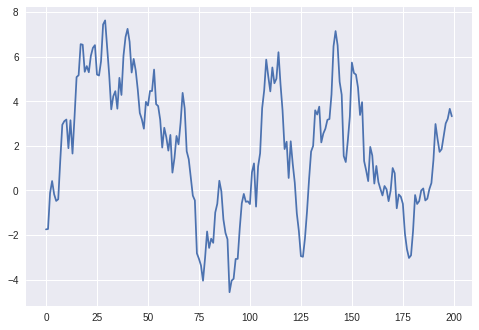

In [33]:
plt.plot(sim_data)
plt.show()

## Autocorrelation function

* For a "stationary" time series $(Z_t)_{1 \leq t \leq \infty}$ define
  $$ACF(t) = \text{ Cor}(Z_s, Z_{s+t}).$$
* Stationary means that correlation above does not depend on $s$.
* For AR(1) model, $$ACF(t) = \rho^t.$$
* For a sample $(Z_1, \dots, Z_n)$ from a stationary time series
  $$\widehat{ACF}(t) = \frac{\sum_{j=1}^{n-t} (Z_j - \overline{Z})(Z_{t+j} - \overline{Z})}{\sum_{j=1}^n(Z_j - \overline{Z})^2}.$$

### ACF of AR(1) noise, $\rho=0.9$

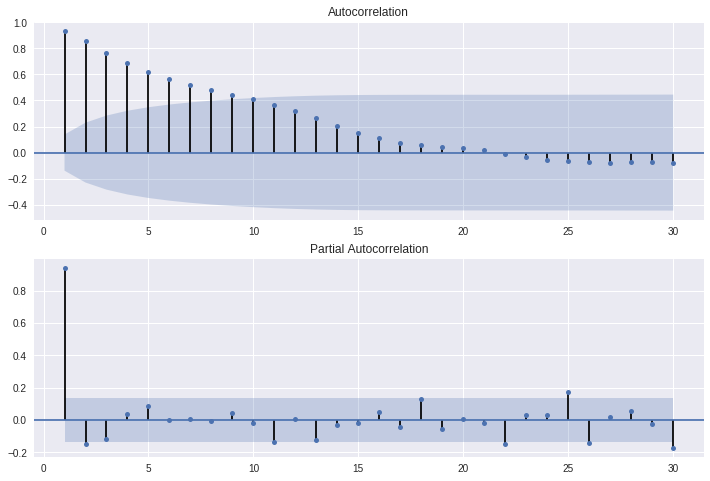

In [34]:
plot_acf_pacf(sim_data, lags=30, zero=False)

### Effects on inference

* So far, we have just mentioned that things *may* be correlated, but
  not thought about how it affects inference.
* Suppose we are in the â€œone sample problemâ€ setting and we observe
  $$W_i  = Z_i + \mu, \qquad 1 \leq i \leq n$$ with the $Z_i$â€™s from
  an $AR(1)$ time series.
* It is easy to see that $$E(\overline{W}) = \mu$$ *BUT*, generally 
  $$\text{Var}(\overline{W}) >  \frac{\text{Var}(Z_1)}{n}$$ how much
  bigger depends on $\rho.$

## Misleading inference ignoring autocorrelation

Just as in weighted least squares, ignoring the autocorrelation
yields misleading `Std. Error` values.

Below, we show that ignoring autocorrelation will yield
incorrect confidence intervals. The red curve is (an estimate of) the true 
density of the sample mean, while the blue curve is what
we think it should be if the errors were independent. The blue
curve is way too optimistic.

In [36]:
# using custom simulation data generator
ntrial = 100
mu = 1.0
rho = 0.95

sample_mean_lst = []
sample_var_lst = []

for i in range(ntrial):
    cur_sample = make_sim_data(rho, nsample) + mu
    sample_mean = np.mean(cur_sample)
    sample_var = np.var(cur_sample, ddof=1)
    sample_mean_lst.append(sample_mean)
    sample_var_lst.append(sample_var)
    
d = dict({"mean": np.mean(sample_mean_lst),
         "stdev": np.sqrt(np.mean(sample_var_lst))})
pd.DataFrame(d, index=[0])

,mean,stdev
0,0.742953,2.851003


In [37]:
# using arma_process.generate_sample
sample_mean_lst = []
sample_var_lst = []

for i in range(ntrial):
    cur_sample = arma_process.generate_sample(nsample=nsample) + mu
    sample_mean = np.mean(cur_sample)
    sample_var = np.var(cur_sample, ddof=1)
    sample_mean_lst.append(sample_mean)
    sample_var_lst.append(sample_var)

d = dict({"mean": np.mean(sample_mean_lst),
         "stdev": np.sqrt(np.mean(sample_var_lst))})
pd.DataFrame(d, index=[0])

,mean,stdev
0,1.047410,2.721895


In [38]:
x = np.arange(-5, 5, 0.05)

In [39]:
Y = np.random.normal(loc=np.mean(sample_mean_lst),
                    scale=np.sqrt(np.mean(sample_var_lst) / nsample),
                    size=nsample)

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


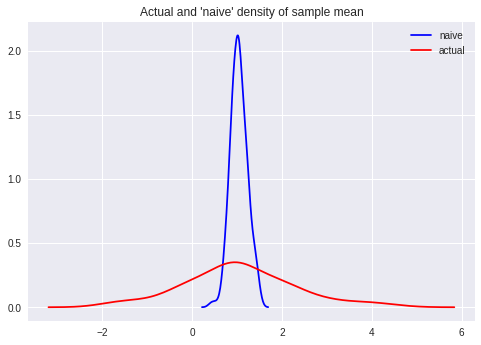

In [41]:
sns.kdeplot(Y, label='naive', color='blue')
sns.kdeplot(np.array(sample_mean_lst), label='actual', color='red')
plt.title("Actual and 'naive' density of sample mean")
plt.show()

## Regression model with auto-correlated errors (AR(1))

* Observations:
  $$Y_t = \beta_0 + \sum_{j=1}^p X_{tj} \beta_j + \varepsilon_t, \qquad 1 \leq t \leq n$$
* Errors:
  $$\varepsilon_t = \rho \cdot \varepsilon_{t-1} + \omega_t, \qquad -1 < \rho < 1$$
* Question: how do we determine if autocorrelation is present?
* Question: what do we do to correct for autocorrelation?

### Graphical checks for autocorrelation

* A plot of residuals vs. time is helpful.
* Residuals clustered above and below 0 line can indicate
  autocorrelation.

### Expenditure vs. stock: residuals

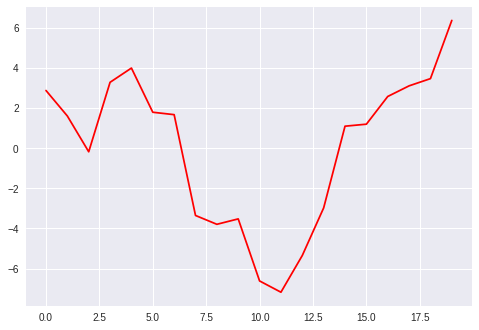

In [42]:
plt.plot(expenditure_res.resid, color='red')
plt.show()

### Durbin-Watson test

* In regression setting, if noise is AR(1), a simple estimate of
  $\rho$ is obtained by (essentially) regressing $e_t$ onto $e_{t-1}$
  $$\widehat{\rho} = \frac{\sum_{t=2}^n \left(e_t e_{t-1}\right)}{\sum_{t=1}^n e_t^2}.$$
* To formally test $H_0:\rho=0$ (i.e. whether residuals are
  independent vs. they are AR(1)), use Durbin-Watson test, based on
  $$d \approx 2(1 - \widehat{\rho}).$$

### Correcting for AR(1)

* Suppose we know $\rho$, we can then â€œwhitenâ€ the data and regressors
  $$\begin{aligned}
     \tilde{Y}_{t+1} &= Y_{t+1} - \rho Y_t, t > 1   \\
     \tilde{X}_{(t+1),j} &= X_{(t+1),j} - \rho X_{t,j}, i > 1
     \end{aligned}$$ for $1 \leq t \leq n-1$. This model satisfies
  â€œusualâ€ assumptions, i.e. the errors
  $$\tilde{\varepsilon}_t = \omega_{t+1} = \varepsilon_{t+1} - \rho \cdot \varepsilon_t$$
  are independent $N(0,\sigma^2)$.
* For coefficients in new model $\tilde{\beta}$,
  $\beta_0 = \tilde{\beta}_0 / (1 - \rho)$,
  $\beta_j = \tilde{\beta}_j.$
* Problem: in general, we don't know $\rho$.

### Two-stage regression

As in weighted least squares, we will use a two-stage procedure.

* Step 1: Fit linear model to unwhitened data (OLS: ordinary least
  squares, i.e. no prewhitening).
* Step 2: Estimate $\rho$ with $\widehat{\rho}$.
* Step 3: Pre-whiten data using $\widehat{\rho}$ â€“ refit the model.

## Whitening

Our solution in the weighted least squares and auto-correlated errors
examples were the same. This procedure is generally called *whitening*.

Consider a model
$$
Y = X\beta + \epsilon, \qquad \epsilon \sim N(0, \Sigma).
$$

If $\Sigma$ is invertible, then we can find a inverse square root of $\Sigma$:
$$
\Sigma^{-1/2}\Sigma (\Sigma^{-1/2})^T = I, \qquad (\Sigma^{-1/2})^T\Sigma^{-1/2} = \Sigma^{-1}.
$$

Define
$$
\tilde{Y} = \Sigma^{-1/2}Y, \qquad \tilde{X} = \Sigma^{-1/2}X.
$$
Then
$$
\tilde{Y} = \tilde{X}\beta + \tilde{\epsilon}, \qquad \tilde{\epsilon} \sim N(0, I).
$$



### Generalized least squares

- The OLS estimator based on $(\tilde{Y}, \tilde{X})$ is 
$$
\hat{\beta}_{\Sigma} = (X^T\Sigma^{-1}X)^{-1}X^T\Sigma^{-1}Y \sim N(\beta, (X^T\Sigma^{-1}X)^{-1})
$$

- It is often called the *GLS (Generalized Least Squares)* estimate based on
the covariance matrix $\Sigma$.

- The OLS estimator based on $(Y,X)$ has the sandwich form again:
$$
\hat{\beta} = (X^TX)^{-1}X^TY \sim N(\beta, (X^TX)^{-1}X^T\Sigma X (X^TX)^{-1}).
$$

- As in WLS, the GLS estimator with $\Sigma=\text{Var}(Y)$ will generally be a more efficient estimator.

- WLS is special case when $\Sigma$ is diagonal.

## Interpreting results of two-stage fit

* Basically, interpretation is unchanged, but the exact degrees of
  freedom in the error is not exactly clear.

* Commonly applied argument: 
  â€œthis works for large degrees of freedom, so we
  hope we have enough degrees of freedom so this point is not
  important.â€

* Can treat $t$-statistics as $Z$-statistics, $F$'s as $\chi^2$,
  appealing to asymptotics:

  * $t_{\nu}$, with $\nu$ large is like $N(0,1)$;
  * $F_{j,\nu}$, with $\nu$ large is like $\chi^2_j/j.$

### Expenditure vs. stock: Durbin-Watson

"The null hypothesis of the test is that there is no serial correlation. 

The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals. Thus, for r == 0, indicating no serial correlation, the test statistic equals 2. This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation."

The alternative hypothesis: rho != 0

Source: https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html

In [54]:
dw = durbin_watson(resids=expenditure_res.resid)
dw
# closer to 0 => more evidence for positive serial correlation

0.3282112654856023

In [56]:
# is there any way to get rho_hat from statsmodels?

# the alternative and approximate way...
# dw is approximately equal to 2(1 − rho_hat)
# where rho_hat = sample autocorrelation of the residuals
# dw = 2 (1 - rho_hat)
# dw/2 = 1 - rho_hat
# rho_hat = 1 - dw/2
rho_hat = 1 - dw/2
rho_hat

0.8358943672571988

Given the value of $\rho$, we can apply our whitening procedure.

In [61]:
expen_whitened = expenditure_data["Expenditure"].iloc[1:].reset_index(drop=True) \
                - rho_hat * expenditure_data["Expenditure"].iloc[:-1].reset_index(drop=True)
    
stock_whitened = expenditure_data["Stock"].iloc[1:].reset_index(drop=True) \
                - rho_hat * expenditure_data["Stock"].iloc[:-1].reset_index(drop=True)

After whitening, we refit the model.

In [71]:
whited_expenditure_res = OLS(expen_whitened, sm.add_constant(stock_whitened)).fit()

/home/doojung/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


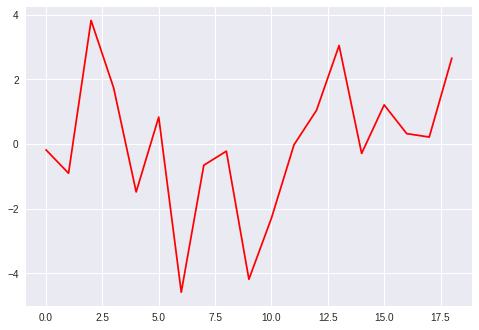

In [72]:
plt.plot(whited_expenditure_res.resid, color='red')
plt.show()

Comparing to our original fit, we see that our $t$ statistic has changed
by a factor of roughly 2.5 from 20 to 8.6!


Actually in my case, t-stat went down to 6 from 20

In [73]:
expenditure_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Expenditure   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     403.2
Date:                Tue, 25 Jun 2019   Prob (F-statistic):           8.99e-14
Time:                        11:56:53   Log-Likelihood:                -54.964
No. Observations:                  20   AIC:                             113.9
Df Residuals:                      18   BIC:                             115.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -154.7192     19.850     -7.794      0.000    -196.423    -113.016
Stock          2.3004      0.115     20.080      0.000       2.060       2.541
==============================================================================
Omnibus:                        2.018   Durbin-Watson:                   0.328
Prob(Omnibus):                  0.365   Jarque-Bera (JB):                1.446
Skew:                          -0.453   Prob(JB):                        0.485
Kurtosis:                       2.044   Cond. No.                     3.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
# actually in my case, t-stat went down to 6
whited_expenditure_res.summary()

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Expenditure   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     34.95
Date:                Tue, 25 Jun 2019   Prob (F-statistic):           1.71e-05
Time:                        11:56:53   Log-Likelihood:                -41.180
No. Observations:                  19   AIC:                             86.36
Df Residuals:                      17   BIC:                             88.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -39.1845     13.893     -2.820      0.012     -68.496      -9.873
Stock          2.7703      0.469      5.911      0.000       1.782       3.759
==============================================================================
Omnibus:                        1.257   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                0.558
Skew:                          -0.420   Prob(JB):                        0.756
Kurtosis:                       3.028   Cond. No.                         804.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Lastly, let's take a look at the residuals of the whitened data. If
our whitening has been successful, this should just be a spike at 0.

/home/doojung/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


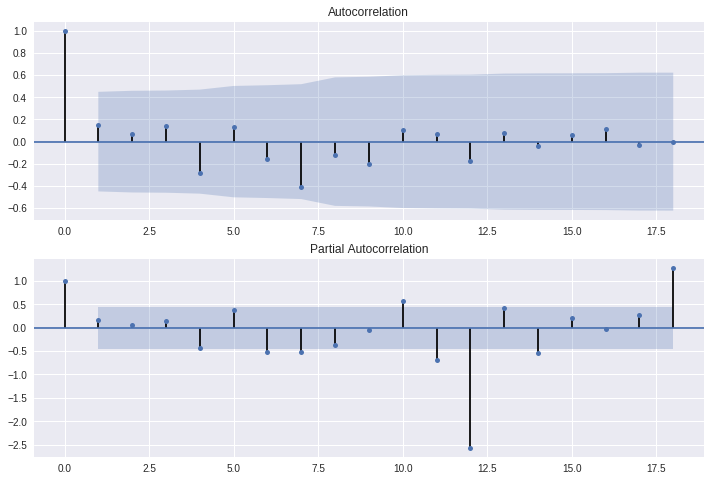

In [75]:
plot_acf_pacf(data=whited_expenditure_res.resid)